In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

In [2]:
gym.logger.set_level(40)

In [3]:
ENV_NAME = 'Pendulum-v0'
input_dim = 3
action_list = [4/10*i-2 for i in range(11)]

In [4]:
NUM_THREADS = 4

#T_max = 10000
MAX_EP = 20000
t_max = 5
print_freq = 500

beta = 0.01   # entropy regularization
gamma = 0.99
alpha = 0.99   # RMSProb decay factor
learning_rate = 1e-4
decay_rate = 0.999

In [5]:
class A3C(nn.Module):
    def __init__(self, input_dim, action_dim, max_ep=0, is_global=False):
        super(A3C, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.max_ep = max_ep
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_dim)
        self.fc5 = nn.Linear(64, 1)
        
        self.ep_counter = None
        self.ep_returns = None
        self.average_returns = None
        
        if is_global:
            self.set_global()
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        Q = self.fc4(x)
        V = self.fc5(x)
        return Q, V
    
    def set_global(self):
        self.ep_counter = mp.Value('i')
        self.ep_counter.value = 0
        self.ep_returns = mp.Array('d', self.max_ep)
        self.average_returns = mp.Array('d',self.max_ep)
        
    def log_episode(self, ep_return):
        c = self.ep_counter.value
        self.ep_returns[c] = ep_return
        self.average_returns[c] = np.mean(self.ep_returns[max(0, c-99):c+1])
        self.ep_counter.value += 1
        return self.ep_counter.value

In [6]:
def train(lock, globalNet, optimizer, scheduler, tmax, pid):
    t = 0
    done = False
    ep_return = 0
    log_episode_return = []
    cur_ep = 0
    
    localNet = A3C(input_dim, len(action_list))
    localNet.load_state_dict(globalNet.state_dict())
    env = gym.make(ENV_NAME)
    obs = env.reset()
    
    while globalNet.ep_counter.value < MAX_EP:
        t_start = t
        buff_value = []
        buff_q = []
        buff_reward = []
        buff_logp = []
        buff_entropy = []
        
        while t_start-t < t_max:
            Q, V = localNet(torch.tensor(obs.astype(np.float32)))
            prob = F.softmax(Q, dim=0).data
            [a] = np.random.choice(localNet.action_dim, 1, p=prob.detach().numpy())
            log_prob = F.log_softmax(Q, dim=0)

            obs, reward, done, _ = env.step([action_list[a]])
            ep_return += reward
            entropy = -(log_prob*prob).sum()

            buff_q.append(Q)
            buff_value.append(V)
            buff_reward.append(reward)
            buff_logp.append(log_prob[a])
            buff_entropy.append(entropy)
            t += 1
            
            if done:
                cur_ep = globalNet.log_episode(ep_return)
                obs = env.reset()
                ep_return = 0
                break

        R = V if not done else 0
        policy_loss = 0
        value_loss = 0
        entropy_loss = 0
        for i in range(-1, -(t-t_start)-1, -1): #range(t-1, t_start-1, -1):
            R = buff_reward[i] + gamma*R
            TD = R - buff_value[i]
            policy_loss += buff_logp[i] * TD.detach()
            value_loss += torch.pow(TD, 2)
            entropy_loss += buff_entropy[i].sum()
        loss = - policy_loss + value_loss - beta*entropy_loss
        
        
        optimizer.zero_grad()
        loss.backward()
        lock.acquire()
        try:
            for local_param, global_param in zip(localNet.parameters(), globalNet.parameters()):
                global_param.grad = local_param.grad
            optimizer.step()
        finally:
            lock.release()
        localNet.load_state_dict(globalNet.state_dict())
        
        if cur_ep%print_freq==0: #globalNet.ep_counter.value%100==0:
            print('[%d] Process'%pid)
            print('%d/%d episodes. (%.2f%%)'%(cur_ep, MAX_EP, cur_ep/MAX_EP*100))
            print('Current learning rate:', optimizer.param_groups[0]['lr'])
            #print(globalNet.ep_counter.value-1, 'episodes.')
            print('Total loss:\t', loss.data.numpy()[0])
            print('Entropy\t\tPolicy\t\tValue')
            print('%.2f\t\t%.2f\t\t%.2f'%(entropy_loss.data.numpy(), policy_loss.data.numpy()[0], \
                  value_loss.data.numpy()[0]))
            print('Epside Return: [%.1f]'%globalNet.average_returns[globalNet.ep_counter.value-1])
            print()
        
        scheduler.step()

In [ ]:
globalNet = A3C(input_dim, len(action_list), MAX_EP, is_global=True)
globalNet.share_memory()
optimizer = optim.Adam(globalNet.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
lock = mp.Lock()

processes = []
for p_idx in range(NUM_THREADS):
    p = mp.Process(target=train, args=(lock, globalNet, optimizer, scheduler, t_max, p_idx))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

[0] Process
500/20000 episodes. (2.50%)
Current learning rate: 8.824417114557706e-05
Total loss:	 34891972.0
Entropy		Policy		Value
138.26		54428.82		34946400.00
Epside Return: [-1328.1]

[1] Process
1000/20000 episodes. (5.00%)
Current learning rate: 7.818259902485651e-05
Total loss:	 12914470.0
Entropy		Policy		Value
0.55		36.41		12914506.00
Epside Return: [-1418.1]

[3] Process
1500/20000 episodes. (7.50%)
Current learning rate: 6.851009179515185e-05
Total loss:	 23956418.0
Entropy		Policy		Value
0.32		11.06		23956430.00
Epside Return: [-1380.3]

[0] Process
2000/20000 episodes. (10.00%)
Current learning rate: 6.0456162655705763e-05
Total loss:	 8651830.0
Entropy		Policy		Value
0.13		3.89		8651834.00
Epside Return: [-1383.3]

[3] Process
2500/20000 episodes. (12.50%)
Current learning rate: 5.3402442084033445e-05
Total loss:	 6871480.0
Entropy		Policy		Value
0.11		2.24		6871482.00
Epside Return: [-1407.0]



## Using Learning Rate Decay & Weight Decay

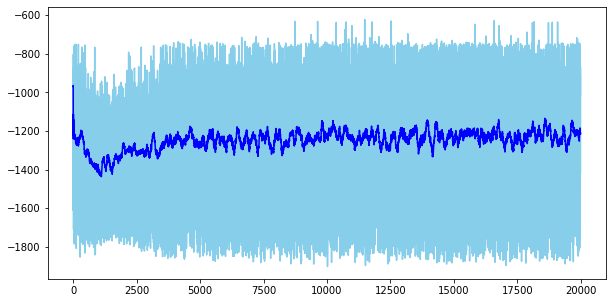

In [9]:
plt.figure(figsize=(10, 5))
average_returns = np.array(globalNet.average_returns[:])
ep_returns = np.array(globalNet.ep_returns[:])
nonzero_indices = average_returns!=0.0
plt.plot(ep_returns[nonzero_indices], color='skyblue')
plt.plot(average_returns[nonzero_indices], color='blue')
fignum = len([f for f in os.listdir() if 'Pendulum' in f and 'png' in f])
#plt.savefig('A3C_Pendulum_%d.png'%fignum)